In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, optimizers

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
#Dataframe labels creation form the CSV files for both test and train sets

df=pd.read_csv('dataset/image/label_binary.csv',dtype=str)
df_test=pd.read_csv('dataset/test/label_binary.csv',dtype=str)

In [22]:
#Image Data generator settings - these are used to generate image data
#for each train test and eval set later
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.20)

#This function extracts the image data from the images and labels
#them correctly according to then name and type specified in df
#    dataframe - pandas DataFrame containing filenames and labels in csv format
#    directory - where the images are saved/stored
#    x_col - column name with image names/ can be index if images are just numbered 1,2,3...
#    y_col - column name with labels
#    subset - training/validation type of data, split determined above in datagen
#    target size - images are downsized to (256,256) for faster traning
#    color_mode - greyscale since we work with single channel images

train_generator=datagen.flow_from_dataframe(
dataframe=df,
directory="dataset/image/",
x_col="file_name",
y_col="label",
subset="training",
batch_size=30,
seed=67,
shuffle=True,
#classes= ['No Tumor','Tumor'],
class_mode="categorical",
target_size=(256,256),
color_mode = "grayscale")

validation_generator=datagen.flow_from_dataframe(
dataframe=df,
directory="dataset/image/",
x_col="file_name",
y_col="label",
subset="validation",
batch_size=30,
seed=67,
shuffle=True,
class_mode="categorical",
#classes= ['No Tumor','Tumor'],
target_size=(256,256),
color_mode = "grayscale")

#separate datagen created for the test unseen data
datagen=ImageDataGenerator(rescale=1./255.)

test=datagen.flow_from_dataframe(
dataframe=df_test,
directory="dataset/test/",
x_col="file_name",
y_col=None,
batch_size=30,
seed=67,
shuffle=False,
class_mode=None,
#classes= ['No Tumor','Tumor'],
target_size=(256,256),
color_mode = "grayscale" )

Found 2392 validated image filenames belonging to 2 classes.
Found 598 validated image filenames belonging to 2 classes.
Found 200 validated image filenames.


In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(256,256,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0

In [7]:
history = model.fit(
        x=train_generator,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=None,
        validation_freq=1,
        max_queue_size=10,
        workers=1,

)

model.save("dataset/model_try_binary.h5",overwrite=True,include_optimizer=True) 
H=pd.DataFrame(history.history)
H.to_csv("Binaryclass_his.csv",index=False)

Epoch 1/15
80/80 [==============================] - 93s 1s/step - loss: 0.9791 - accuracy: 0.8365 - val_loss: 0.3539 - val_accuracy: 0.8612
Epoch 2/15
80/80 [==============================] - 90s 1s/step - loss: 0.3362 - accuracy: 0.8566 - val_loss: 0.2675 - val_accuracy: 0.8696
Epoch 3/15
80/80 [==============================] - 92s 1s/step - loss: 0.2484 - accuracy: 0.8796 - val_loss: 0.2010 - val_accuracy: 0.9147
Epoch 4/15
80/80 [==============================] - 91s 1s/step - loss: 0.2210 - accuracy: 0.8926 - val_loss: 0.1808 - val_accuracy: 0.9365
Epoch 5/15
80/80 [==============================] - 92s 1s/step - loss: 0.1825 - accuracy: 0.9197 - val_loss: 0.1628 - val_accuracy: 0.9465
Epoch 6/15
80/80 [==============================] - 91s 1s/step - loss: 0.1503 - accuracy: 0.9402 - val_loss: 0.1451 - val_accuracy: 0.9415
Epoch 7/15
80/80 [==============================] - 91s 1s/step - loss: 0.1221 - accuracy: 0.9515 - val_loss: 0.1232 - val_accuracy: 0.9548
Epoch 8/15
80/80 [==

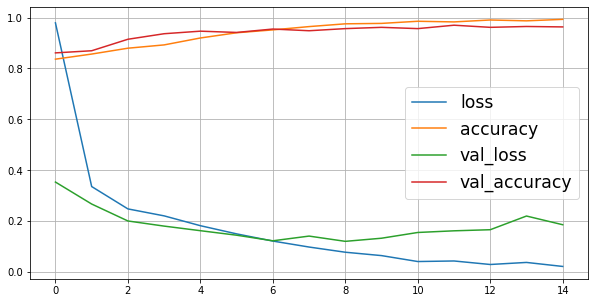

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

Hist = pd.DataFrame(H).plot(figsize=(10,5))
Hist.plot(figsize=(20,10))
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

In [13]:
H

,loss,accuracy,val_loss,val_accuracy
0,0.979135,0.836538,0.353852,0.861204
1,0.336229,0.856605,0.267532,0.869565
2,0.248396,0.879599,0.200999,0.914716
3,0.221038,0.892559,0.180839,0.936455
4,0.182461,0.919732,0.162823,0.946488
5,0.150343,0.940217,0.145111,0.941472
6,0.122060,0.951505,0.123165,0.954849
7,0.098624,0.964465,0.141639,0.948161
8,0.078260,0.975334,0.120991,0.956522
9,0.064965,0.977007,0.133269,0.961538


In [16]:
model.evaluate(
    x=validation_generator,
    steps = 19
)

19/19 [==============================] - 4s 176ms/step - loss: 0.1949 - accuracy: 0.96142s - loss:


[0.19487886130809784, 0.961403489112854]

In [23]:
test_generator = test
#predict results based on the model generated
pred=model.predict(test_generator,verbose=1)
print("predictions shape:", pred.shape)

predicted_class_indices=np.argmax(pred,axis=1)

7/7 [==============================] - 1s 160ms/step
predictions shape: (200, 2)


In [55]:
#labels and filenames have to be sorted now because of the shuffle function
#used for the data generators
labels = (train_generator.class_indices)
labels = dict((a,b) for b,a in labels.items())
predictions = [labels[i] for i in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [54]:
evals = results.Predictions == df_test.label
print('Test accuracy on the 200 unseen data is ',np.count_nonzero(evals)/len(evals),'%')

Test accuracy on the 200 unseen data is  0.955 %
